# Chapter 10: Approximability Models

In [1]:
import numpy as np
from scipy import linalg as LA
from scipy import integrate
import cvxpy as cp
import matplotlib.pyplot as plt

## Hilbert setting

Note that the observation map, denoted $\Lambda$ in the text, is denoted $L$ here.

In [2]:
# generate the approximation space V and the observation map L
N = 40                         # dimension of the ambient Hilbert space
n = 9                          # dimension of the space V
epsilon = 0.1                  # the approximation parameter
V = np.random.randn(N,n)       # the columns of this matrix form a basis of the space V
V = V@LA.inv(LA.sqrtm(V.T@V))  # the columns now form an orthonormal basis
m = 22                         # number of observations
L = np.random.randn(m,N)       # the observation map
# generate an element in the approximability set and its observation vector
aux = np.random.randn(N,1)
f = V@np.random.rand(n,1) + (2/3)*epsilon*aux/LA.norm(aux)
y = L@f                                              

Produce the Chebyshev center $f^\star$ (according to Proposition 10.3) and the compatibility parameter $\mu$ (according to Theorem 10.4).

In [3]:
# define the Gramian Gu and the cross-Gramian C (the Gramian Gv is the identity)
Gu = L@L.T
C = L@V
# produce f_star
Gu_inv = LA.inv(Gu)
b = LA.solve(C.T@Gu_inv@C,C.T@Gu_inv@y)
a = Gu_inv@(y-C@b)
f_star = L.T@a + V@b
# produce mu
mu = 1/np.sqrt(min(LA.eigh(C.T@Gu_inv@C,eigvals_only=True)))

Compute the local worst-case error at $f^\star$ by two different methods:
- the one which is implicit in (10.7)-(10.8);
- the one, valid for an arbitrary $f$ instead of $f^\star$, which is to be found later in Exercise 23.2.

In [4]:
# the worst-case error using the first method
P1 = np.identity(N) - V@V.T    # the orthogonal projector onto the orthogonal space to V 
wce1 = mu*np.sqrt(epsilon**2 - LA.norm(P1@f_star)**2)
# the worst-case error using the second method
Q,R = LA.qr(L.T)
K = Q[:,m:N]                   # the columns form an orthonormal basis for ker(L) 
P2 = K@LA.inv(K.T@K)@K.T       # the orthogonal projector onto ker(L)
h = L.T@LA.solve(L@L.T,y)      # the element orthogonal to ker(L) for which L(h)=y
c = cp.Variable((1,1))
d = cp.Variable((1,1),nonneg=True)
objective = cp.Minimize(c)
a11 = K.T@(d*P1-np.identity(N))@K
a12 = K.T@(d*P1@h+P2@f_star)
a22 = c+d*(LA.norm(P1@h)**2-epsilon**2)
constraints = [ cp.vstack( (cp.hstack((a11, a12)),cp.hstack((a12.T,a22))) )>>0]
wce_SDP = cp.Problem(objective,constraints)
wce_SDP.solve()
wce2 = np.sqrt( LA.norm(h-f_star+P2@f_star)**2 + LA.norm(P2@f_star)**2 + c.value[0,0] )
print('The two worst-case errors are {:.4f} and {:.4f}: they are indeed identical.'.format(wce1,wce2))

The two worst-case errors are 0.2128 and 0.2128: they are indeed identical.


## Real-valued quantity of interest

The example considered here consists of the optimal estimation of the integral of a univariate function $f\in C([-1,1])$ given its point values at $m$ equispaced points $x^{(1)},\dots,x^{(m)}\in[-1,1]$.

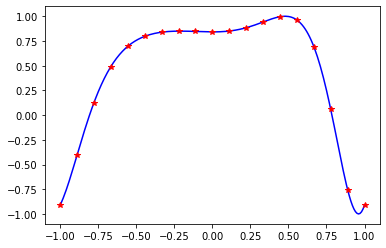

In [5]:
# generate a function f and its vector of point values
def f(x):
    return np.sin(np.pi*x**3+x**2+1)
m = 19
eqpts = np.linspace(-1,1,m)
y = f(eqpts)
grid = np.linspace(-1,1,201)
plt.plot(grid,f(grid),'b-',eqpts,y,'r*')
plt.show()

An optimal quadrature rule has the form $y\in \mathbb{R} \mapsto \sum_{i=1}^{m} a_i^\star y_i\in\mathbb{R}$, where the vector $a^\star\in\mathbb{R}^m$ is a solution to
$$ \mathop{\mathrm{minimize}}_{a\in\mathbb{R}^m} \sum_{i=1}^{m} |a_i| \quad \mbox{ subject to }\quad \sum_{i=1}^{m}a_iv_j(x^{(i)}) = \int_{-1}^{1} v_j(x)dx, \quad j=1,\dots,n,$$
where $(v_1,\dots,v_n)$ denotes a basis for the space $\mathcal{V}$, chosen here to be made of polynomials of degree $<n$. 

Note that the optimal rule is independent of the parameter $\varepsilon$ defining the approximability model.

In [6]:
# choose the monomial basis and compute a vector of optimal quadrature weights
n = 9
M = np.zeros((n,m))     # the matrix involved in the equality constraint
b = np.zeros(n)         # the right-hand side of the equality constraint
for j in range(n):
    M[j,:] = eqpts**j
    b[j] = (1-(-1)**(j+1))/(j+1)
a_star = cp.Variable(m)
objective = cp.Minimize(cp.norm1(a_star))
constraints = [M@a_star==b]
L1 = cp.Problem(objective,constraints)
L1.solve()
a_star = a_star.value
print('The optimal estimation of the integral is {:.4f}, while the true integral is {:.4f}, corresponding to a relative error of {:.4f}.'.
     format(y@a_star, integrate.quad(f,-1,1)[0], abs(y@a_star-integrate.quad(f,-1,1)[0])/integrate.quad(f,-1,1)[0]) )

The optimal estimation of the integral is 0.9749, while the true integral is 0.9765, corresponding to a relative error of 0.0016.


Does the computed weight vector $a^\star\in\mathbb{R}^m$ have sparsity at most $n$?

In [7]:
print('The sparsity of the computed weight vector is {:d}.'.format(sum(abs(a_star)>1e-3)))

The sparsity of the computed weight vector is 19.


This is not a contradiction with the claim that $\textit{one of}$ the minimizers is $n$-sparse: if there are several minimizers, then some of them might not be sparse! Outputting a sparse minimizer depends on the algorithm being execute (and in turn on the CVX solver being used). The simplex algorithm does output a sparse solution.

In [8]:
ap = cp.Variable(m,nonneg=True)
am = cp.Variable(m,nonneg=True)
objective = cp.Minimize(cp.sum(ap+am))
constraints = [M@(ap-am)==b]
sparse = cp.Problem(objective,constraints)
sparse.solve(solver='SCS')
a_star2 = ap.value-am.value
print('This time, the sparsity of the computed weight vector is {:d}.'.format(sum(abs(a_star2)>1e-3)))

This time, the sparsity of the computed weight vector is 19.
